In [1]:

import os
import time
import torch
import numpy as np
import scipy.stats
from collections import defaultdict
from torch.distributions import constraints

import pyro
import pyro.distributions as dist

from pyro import poutine
from pyro.infer.autoguide import AutoDelta
from pyro.optim import Adam
from pyro.infer import SVI, TraceEnum_ELBO, config_enumerate, infer_discrete

pyro.clear_param_store()
pyro.set_rng_seed(1)


In [2]:

import pandas as pd
import numpy as np

rtdata = pd.read_csv('mcfrt.csv')
rtdata = rtdata.query('chr == "1"')
rtdata


,chr,start,end,gc,mcf7rt,bin_size
0,1,1000000,1500000,0.598330,81.441980,500000
1,1,1500000,2000000,0.539496,79.131013,500000
2,1,2000000,2500000,0.594508,78.557313,500000
3,1,3000000,3500000,0.584570,70.388076,500000
4,1,4000000,4500000,0.482572,48.663092,500000
...,...,...,...,...,...,...
423,1,246000000,246500000,0.404142,47.146415,500000
424,1,246500000,247000000,0.428546,70.978030,500000
425,1,247000000,247500000,0.425162,58.722962,500000
426,1,247500000,248000000,0.400436,30.497224,500000


In [3]:

import matplotlib.pyplot as plt
import seaborn as sns

rtdata['norm_mcf7rt'] = (rtdata['mcf7rt'] - rtdata['mcf7rt'].min()) / (rtdata['mcf7rt'].max() - rtdata['mcf7rt'].min())

sns.lineplot(x='start', y='norm_mcf7rt', data=rtdata)


<AxesSubplot:xlabel='start', ylabel='norm_mcf7rt'>

In [4]:

starts = rtdata['start'].values
rt = rtdata['norm_mcf7rt'].values
num_cells = 170
num_loci = 200

cn = np.ones((rt.shape[0], num_cells)) * 2

starts = starts[:num_loci]
rt = torch.tensor(rt[:num_loci])
cn = torch.tensor(cn[:num_loci, :])

# add a CNA for 30 cells in the first 30 bins
cn[:30, :30] = 1

### Play around with using true `cn` to create a reasonable prior for `cn_prob`

In [5]:
num_states = 13

# build the transition matrix using cn
def build_trans_mat(cn, num_states=13):
    num_loci, num_cells = cn.shape
    trans_mat = torch.eye(num_states, num_states) + 1
    for i in range(num_cells):
        for j in range(1, num_loci):
            cur_state = int(cn[j, i])
            prev_state = int(cn[j-1, i])
            trans_mat[prev_state, cur_state] += 1
    return trans_mat

def create_cn_prior(true_cn, weight=1e6, num_states=13):
    num_loci, num_cells = true_cn.shape
    cn_prior = torch.ones(num_loci, num_cells, num_states)
    for i in range(num_loci):
        for n in range(num_cells):
            state = int(true_cn[i, n].numpy())
            cn_prior[i, n, state] = weight
    return cn_prior

cn_prior = create_cn_prior(cn, num_states=num_states)
cn_prior_1 = create_cn_prior(cn, weight=1e9, num_states=num_states)
trans_mat = build_trans_mat(cn, num_states=num_states)

### Define generative model

In [6]:
@config_enumerate
def model_S1(args):
    assert ('num_cells' in args) or ('data' in args) or ('cn0' in args)

    if 'data' in args:
        num_loci, num_cells = args['data'].shape
    elif 'cn0' in args:
        num_loci, num_cells = args['cn0'].shape
    else:
        num_loci = args['num_loci']
        num_cells = args['num_cells']

    # controls the consistency of replicating on time
    a = pyro.sample('expose_a', dist.Gamma(torch.tensor([2.]), torch.tensor([0.2])))
    
    # use rt0 as an informed prior if provided
    if 'rt0' in args:
        with pyro.plate('num_loci0', num_loci):
            # bulk replication timing profile
            rt = pyro.sample('expose_rt', dist.Normal(args['rt0'], 0.1))
    else:
        with pyro.plate('num_loci0', num_loci):
            # bulk replication timing profile
            rt = pyro.sample('expose_rt', dist.Normal(torch.ones(num_loci)*0.5, 0.1))
    
    # fix cn as constant when input into model
    if 'cn0' in args:
        cn = args['cn0']

    with pyro.plate('num_cells', num_cells):

        # per cell replication time
        t = pyro.sample('expose_t', dist.Beta(torch.tensor([1.]), torch.tensor([1.])))

        # per cell reads per copy per bin
        u = pyro.sample('expose_u', dist.Normal(torch.tensor([70.]), torch.tensor([10.])))

        with pyro.plate('num_loci', num_loci):
            
            if 'cn0' not in args:
                if 'cn_prior' not in args:
                    cn_prior = torch.ones(num_loci, num_cells, 13)
                else:
                    cn_prior = args['cn_prior']
                # sample cn probabilities of each bin from Dirichlet
                cn_prob = pyro.sample('expose_cn_prob', dist.Dirichlet(cn_prior))
                # sample cn state from categorical based on cn_prob
                cn = pyro.sample('cn', dist.Categorical(cn_prob))

            # per cell per bin late or early 
            t_diff = t.reshape(-1, num_cells) - rt.reshape(num_loci, -1)

            # probability of having been replicated
            p_rep = 1 / (1 + torch.exp(-a * t_diff))

            # binary replicated indicator
            rep = pyro.sample('rep', dist.Bernoulli(p_rep))

            # copy number accounting for replication
            rep_cn = cn * (1. + rep)

            # negative binomial dispersion
            nb_r = pyro.param('expose_nb_r', torch.tensor([10000.0]), constraint=constraints.positive)

            # expected reads per bin per cell
            expected_reads = (u * rep_cn)

            nb_p = expected_reads / (expected_reads + nb_r)
            
            if 'data' in args:
                obs = args['data']
            else:
                obs = None
            
            reads = pyro.sample('reads', dist.NegativeBinomial(nb_r, probs=nb_p), obs=obs)

### Simulate and visualize data

In [7]:

# Simulate conditioned on a, get reads, replication timing etc

pyro.clear_param_store()

conditioned_model = poutine.condition(
    model_S1,
    data={
        'expose_a': torch.tensor([10.]),
        'expose_rt': rt
    })

model_trace = pyro.poutine.trace(conditioned_model)

args = {'cn0': cn}

samples = model_trace.get_trace(args)

t = samples.nodes['expose_t']['value']
a = samples.nodes['expose_a']['value']
u = samples.nodes['expose_u']['value']
nb_r = samples.nodes['expose_nb_r']['value']

t_diff = t.reshape(-1, num_cells) - rt.reshape(num_loci, -1)
p_rep = 1 / (1 + torch.exp(-a * t_diff))

rep = samples.nodes['rep']['value']

rep_cn = cn * (1. + rep)

reads = samples.nodes['reads']['value']


/juno/work/shah/users/weinera2/projects/scdna_replication_tools/venv2/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


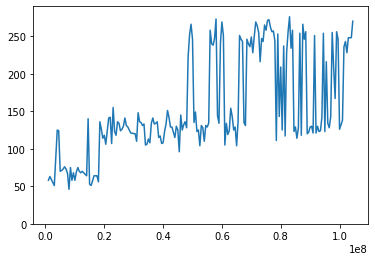

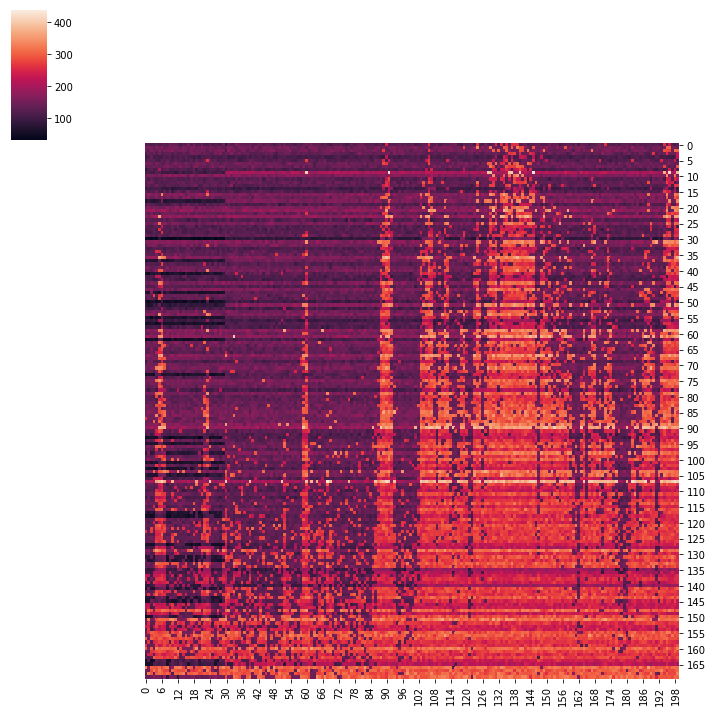

In [8]:
# Visualize one cell and matrix

sns.lineplot(starts, reads[:, 1])
plt.ylim((0, 1.05 * reads[:, 1].max()))

sns.clustermap(reads.numpy().astype(float).T[np.argsort(t), :], col_cluster=False, row_cluster=False)

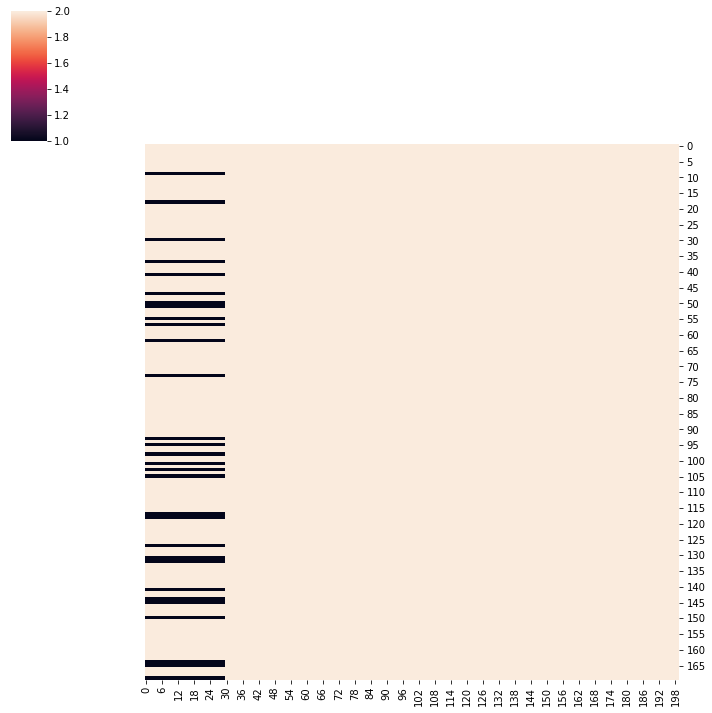

In [9]:
# visualize the true copy number heatmap
sns.clustermap(cn.numpy().astype(float).T[np.argsort(t), :], col_cluster=False, row_cluster=False)
plt.show()

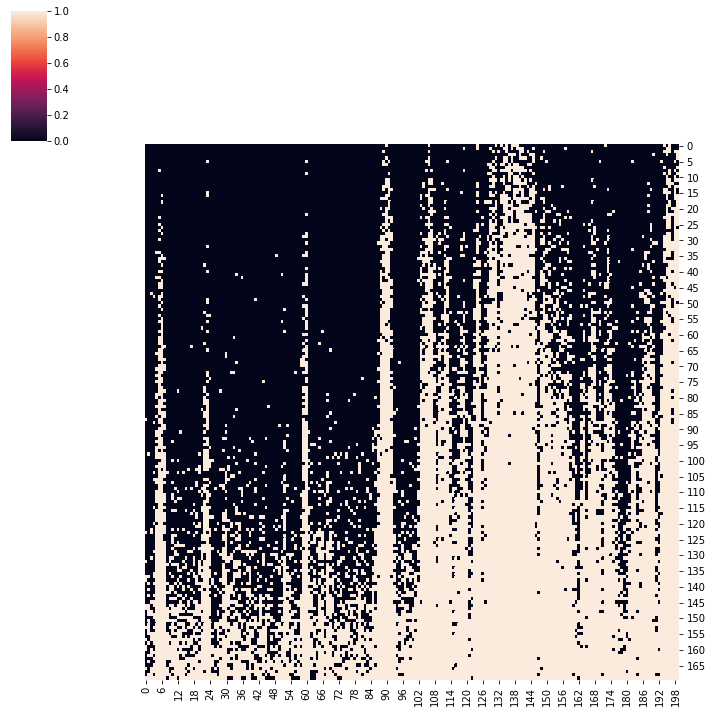

In [10]:
# visualize the true replication heatmap
sns.clustermap(rep.numpy().astype(float).T[np.argsort(t), :], col_cluster=False, row_cluster=False)
plt.show()

/juno/work/shah/users/weinera2/projects/scdna_replication_tools/venv2/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


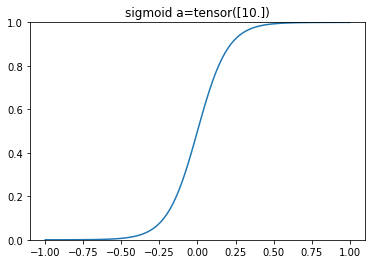

In [11]:
def plot_sigmoid(a):
    x = np.linspace(-1, 1, 101)
    y = 1 / (1 + np.exp(-a * x))

    sns.lineplot(x, y)
    plt.title(f'sigmoid a={a}')
    plt.ylim((0, 1))

plot_sigmoid(samples.nodes['expose_a']['value'].detach())


### Normalize each cell to the same total number of reads

In [12]:
reads_per_cell = torch.mean(reads) * num_loci
reads_norm = (reads / torch.sum(reads, 0)) * reads_per_cell
reads_norm = reads_norm.type(torch.int64)

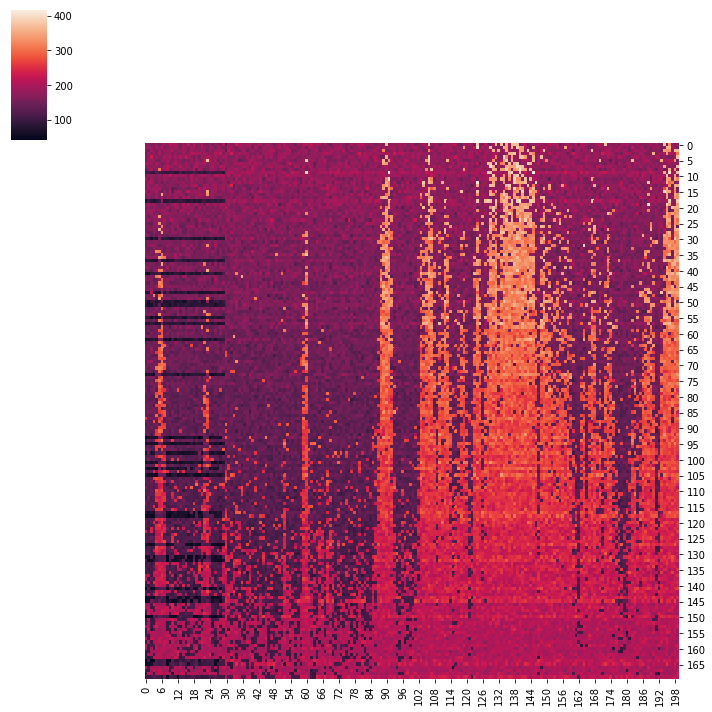

In [13]:
sns.clustermap(reads_norm.numpy().astype(float).T[np.argsort(t), :], col_cluster=False, row_cluster=False)
plt.show()

### Infer all relevant params just taking `reads_norm` as input

In [14]:
cn = cn.type(torch.float32)
reads = reads.type(torch.float32)
reads_norm = reads_norm.type(torch.float32)
cn_prior = cn_prior.type(torch.float32)
rt = rt.type(torch.float32)

In [15]:
def test_model_runtime(model, model_input, max_plate_nesting=2, first_available_dim=-3, 
                       condition_dict={}, num_iter=20, plot_loss=True):
    pyro.clear_param_store()
    
    optim = pyro.optim.Adam({'lr': 0.01, 'betas': [0.8, 0.99]})
    elbo = TraceEnum_ELBO(max_plate_nesting=max_plate_nesting)
    
    conditioned_model = poutine.condition(
        model,
        data=condition_dict
    )
    
    guide = AutoDelta(
        poutine.block(conditioned_model, expose_fn=lambda msg: msg["name"].startswith("expose_"))
    )
    svi = SVI(conditioned_model, guide, optim, loss=elbo)
    
    pyro.clear_param_store()
    
    print('running svi')
    losses = []
    iter_times = []
    prev_time = time.time()
    for i in range(num_iter):
        #TODO: make input to svi.step() generalizable
        loss = svi.step(args=model_input)
        cur_time = time.time()
        iter_times.append(cur_time - prev_time)
        prev_time = cur_time
        losses.append(loss)
        print('.', end='')
    
    if plot_loss:
        plt.figure(figsize=(10,3), dpi=100).set_facecolor('white')
        plt.plot(losses)
        plt.xlabel('iters')
        plt.ylabel('loss')
        plt.title('Convergence of SVI')
        plt.show()
    
    # get trace of discrete params
    guide_trace = poutine.trace(guide).get_trace(args=model_input)
    trained_model = poutine.replay(conditioned_model, trace=guide_trace)

    inferred_model = infer_discrete(
        trained_model, temperature=0,
        first_available_dim=first_available_dim)
    trace = poutine.trace(inferred_model).get_trace(args=model_input)

    return trace, iter_times


def plot_model_heatmaps(trace, t, cn_name='cn', rep_name='rep', model_name='model'):
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    
    sns.heatmap(trace.nodes[cn_name]["value"].numpy().astype(float).T[np.argsort(t), :],
               ax=axs[0])
    axs[0].set_title('CN inferred by {}'.format(model_name))
    axs[0].set_ylabel('cells')
    axs[0].set_xlabel('loci')
    sns.heatmap(trace.nodes[rep_name]["value"].numpy().astype(float).T[np.argsort(t), :],
               ax=axs[1])
    axs[1].set_title('Rep inferred by {}'.format(model_name))
    axs[1].set_ylabel('cells')
    axs[1].set_xlabel('loci')
    plt.show()

    
def extract_hmm_trace_output(trace, cn, rep_name='rep', cn_name='cn'):
    model_rep = torch.zeros(cn.shape)
    model_cn = torch.zeros(cn.shape)
    for l in range(cn.shape[0]):
        temp_rep = trace.nodes['{}_{}'.format(rep_name, l)]['value']
        temp_cn = trace.nodes['{}_{}'.format(cn_name, l)]['value']
        model_rep[l] = temp_rep
        model_cn[l] = temp_cn
    return model_cn, model_rep
    

def plot_hmm_model_heatmaps(trace, t, cn, cn_name='cn', rep_name='rep', model_name='model'):
    model_cn, model_rep = extract_hmm_trace_output(trace, cn, rep_name=rep_name, cn_name=cn_name)
    
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    
    sns.heatmap(model_cn.numpy().astype(float).T[np.argsort(t), :],
               ax=axs[0])
    axs[0].set_title('CN inferred by {}'.format(model_name))
    axs[0].set_ylabel('cells')
    axs[0].set_xlabel('loci')
    sns.heatmap(model_rep.numpy().astype(float).T[np.argsort(t), :],
               ax=axs[1])
    axs[1].set_title('Rep inferred by {}'.format(model_name))
    axs[1].set_ylabel('cells')
    axs[1].set_xlabel('loci')
    plt.show()


def plot_iter_times(iter_times, model_name='model'):
    fig, ax = plt.subplots(1, 1, figsize=(6, 6))
    sns.scatterplot(x=range(len(iter_times)), y=iter_times, ax=ax)
    ax.set_xlabel('iter')
    ax.set_ylabel('time (s)')
    ax.set_title('Runtime for {}'.format(model_name))
    plt.show()
    


running svi
....................

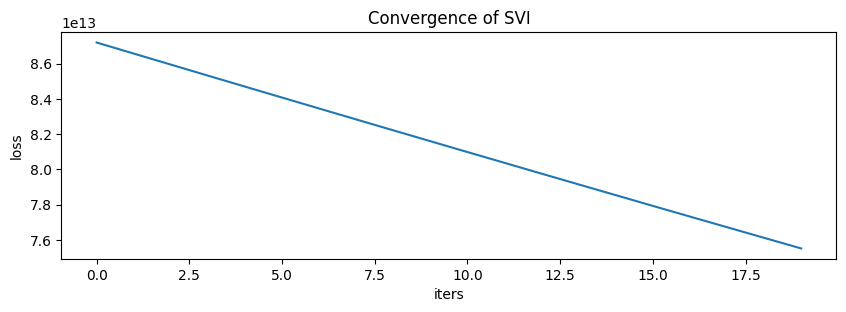

In [16]:
trace, iter_times = test_model_runtime(model_S1, {'data': reads, 'cn_prior': cn_prior_1})

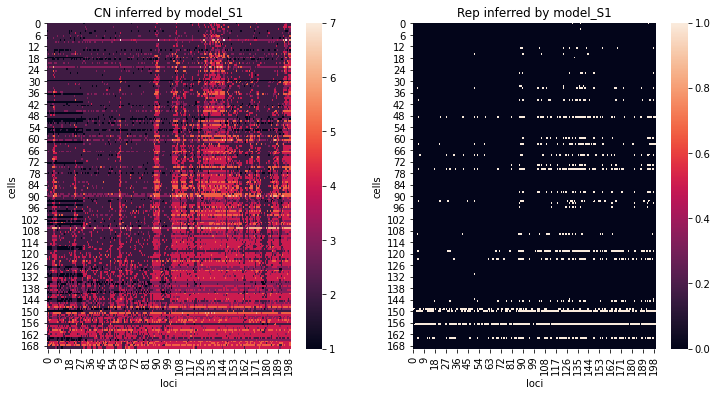

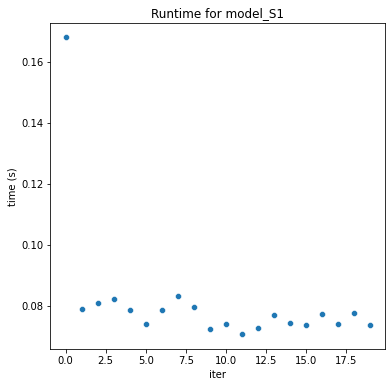

In [17]:
plot_model_heatmaps(trace, t, model_name=model_S1.__name__)
plot_iter_times(iter_times, model_name=model_S1.__name__)

### Now try to infer with a model that has an HMM structure for copy number

In [18]:
@config_enumerate
def model_S2(args):
    assert ('num_cells' in args) or ('data' in args) or ('cn0' in args)

    if 'data' in args:
        num_loci, num_cells = args['data'].shape
    elif 'cn0' in args:
        num_loci, num_cells = args['cn0'].shape
    else:
        num_loci = args['num_loci']
        num_cells = args['num_cells']


    # controls the consistency of replicating on time
    a = pyro.sample('expose_a', dist.Gamma(torch.tensor([2.]), torch.tensor([0.2])))
    
    # use rt0 as an informed prior if provided
    if 'rt0' in args:
        with pyro.plate('num_loci0', num_loci):
            # bulk replication timing profile
            rt = pyro.sample('expose_rt', dist.Normal(args['rt0'], 0.1))
    else:
        with pyro.plate('num_loci0', num_loci):
            # bulk replication timing profile
            rt = pyro.sample('expose_rt', dist.Normal(torch.ones(num_loci)*0.5, 0.1))
    
    # fix cn as constant when input into model
    if 'cn0' in args:
        cn0 = args['cn0']

    with pyro.plate('num_cells', num_cells):

        # per cell replication time
        t = pyro.sample('expose_t', dist.Beta(torch.tensor([1.]), torch.tensor([1.])))

        # per cell reads per copy per bin
        u = pyro.sample('expose_u', dist.Normal(torch.tensor([70.]), torch.tensor([10.])))
        
        if 'cn0' not in args:
            cn = 2

        for l in pyro.markov(range(num_loci)):
            
            # sample copy number states using HMM structure
            if 'cn0' not in args:
                trans_mat = args['trans_mat']
                cn_prior = args['cn_prior']
                temp_cn_prob = trans_mat[cn] * cn_prior[l]
                cn = pyro.sample("cn_{}".format(l), dist.Categorical(temp_cn_prob),
                                 infer={"enumerate": "parallel"})
            else:
                # no need to sample cn when true cn0 is provided to the model
                cn = cn0[l]

            # per cell per bin late or early 
            time_diff = t.reshape(-1, num_cells) - rt[l]

            # probability of having been replicated
            p_rep = 1 / (1 + torch.exp(-a * time_diff))

            # binary replicated indicator
            rep = pyro.sample('rep_{}'.format(l), dist.Bernoulli(p_rep))
            
            # copy number accounting for replication
            rep_cn = cn * (1. + rep)

            # negative binomial dispersion
            nb_r = pyro.param('expose_nb_r', torch.tensor([10000.0]), constraint=constraints.positive)

            # expected reads per bin per cell
            expected_reads = (u * rep_cn)

            nb_p = expected_reads / (expected_reads + nb_r)
            
            if 'data' in args:
                obs = args['data'][l]
            else:
                obs = None
            
            reads = pyro.sample('reads_{}'.format(l), dist.NegativeBinomial(nb_r, probs=nb_p), obs=obs)

# pyro.render_model(model_S2, model_args=(None, None, None, None, reads, cn_prior, trans_mat), 
#                   render_distributions=True, render_params=True)

running svi
....................

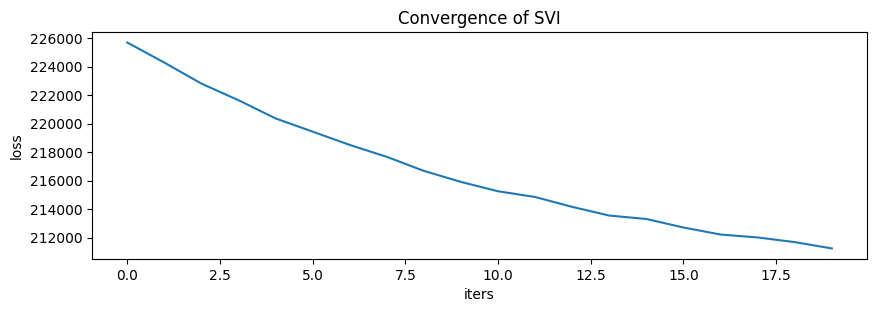

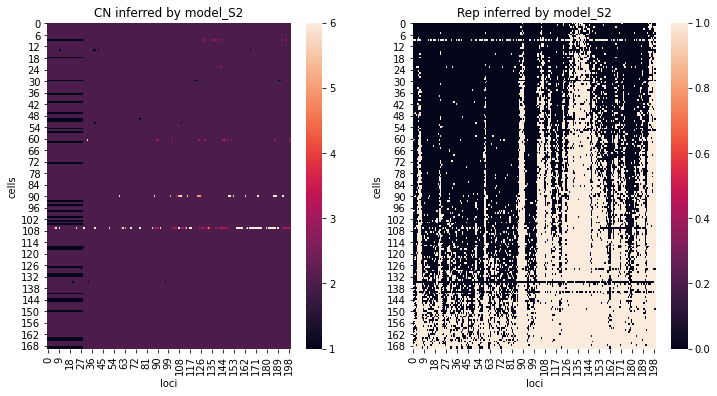

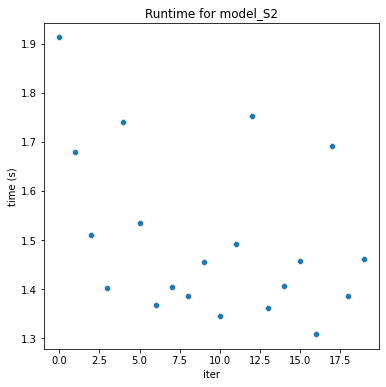

In [19]:
trace, iter_times = test_model_runtime(model_S2, {'data': reads, 'cn_prior': cn_prior, 'trans_mat': trans_mat})
plot_hmm_model_heatmaps(trace, t, cn, model_name=model_S2.__name__)
plot_iter_times(iter_times, model_name=model_S2.__name__)

running svi
....................

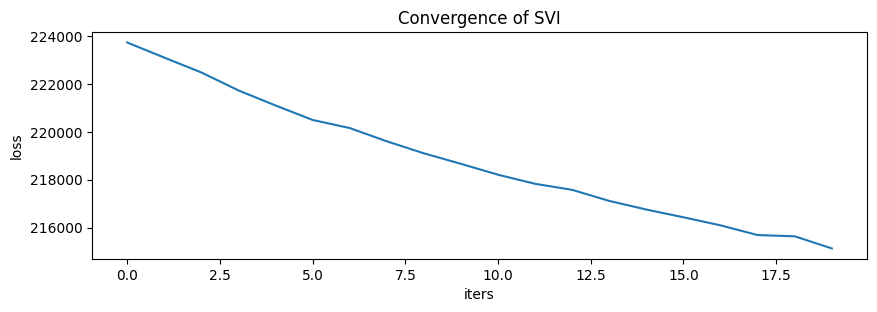

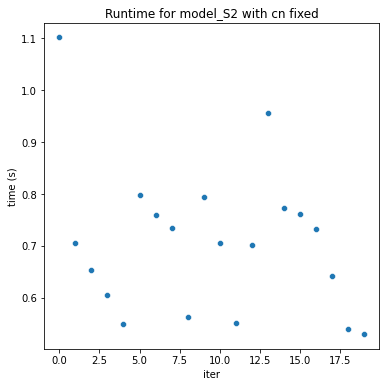

In [20]:
# see what the hmm model looks like when cn is fixed
name = 'model_S2 with cn fixed'
trace, iter_times = test_model_runtime(model_S2, {'data': reads, 'cn0': cn})
# plot_hmm_model_heatmaps(trace, t, cn, model_name=name)
plot_iter_times(iter_times, model_name=name)

### Trying to take advantage of dist.DiscreteHMM() to run HMM in log(n) instead of linear time

Notable issues:
- Having multiple priors & sample statements that go into `obs_logits` and `init_logits`
- How to keep `trans_mat` fixed instead of inferring it
- How to ensure that `cn` is modeled by HMM but `rep` is not

In [21]:
@config_enumerate
def model_S3(args):
    assert ('num_cells' in args) or ('data' in args) or ('cn0' in args)

    if 'data' in args:
        num_loci, num_cells = args['data'].shape
    elif 'cn0' in args:
        num_loci, num_cells = args['cn0'].shape
    else:
        num_loci = args['num_loci']
        num_cells = args['num_cells']


    # controls the consistency of replicating on time
    a = pyro.sample('expose_a', dist.Gamma(torch.tensor([2.]), torch.tensor([0.2])))
    
    # use rt0 as an informed prior if provided
    if 'rt0' in args:
        with pyro.plate('num_loci0', num_loci):
            # bulk replication timing profile
            rt = pyro.sample('expose_rt', dist.Normal(args['rt0'], 0.1))
    else:
        with pyro.plate('num_loci0', num_loci):
            # bulk replication timing profile
            rt = pyro.sample('expose_rt', dist.Normal(torch.ones(num_loci)*0.5, 0.1))
    
    # fix cn as constant when input into model
    if 'cn0' in args:
        cn0 = args['cn0']
    
    if 'trans_mat' in args:
        trans_probs = pyro.sample(
            'expose_trans_probs', 
            dist.Dirichlet(args['trans_mat']).to_event(1)
        )
        hidden_dim = trans_mat.shape[0]
    else:
        if 'hidden_dim' in args:
            hidden_dim = args['hidden_dim']
        else:
            hidden_dim = 13
        trans_probs = pyro.sample(
            'expose_trans_probs',
            dist.Dirichlet(0.9 * torch.eye(hidden_dim) + 0.1).to_event(1)
        )
        

    with pyro.plate('num_cells', num_cells):

        # per cell replication time
        t = pyro.sample('expose_t', dist.Beta(torch.tensor([1.]), torch.tensor([1.])))

        # per cell reads per copy per bin
        u = pyro.sample('expose_u', dist.Normal(torch.tensor([70.]), torch.tensor([10.])))
        
        if 'cn0' not in args:
#             cn = torch.ones(num_loci, num_cells, hidden_dim)
#             for i in range(hidden_dim):
#                 cn[:, :, i] = i
            cn = torch.ones(num_loci, num_cells) * 2.0
            init_logits = torch.full((hidden_dim,), -float("inf"))
            init_logits[0] = 0
            trans_logits = trans_probs.log()

            # per cell per bin late or early 
            print('t', t.shape)
            print('rt', rt.shape)
            t_diff = t.reshape(-1, num_cells) - rt.reshape(num_loci, -1)

            # probability of having been replicated
            p_rep = 1 / (1 + torch.exp(-a * t_diff))

            # binary replicated indicator
            rep = pyro.sample('rep', dist.Bernoulli(p_rep))

            # copy number accounting for replication
            print('cn', cn.shape)
            print('rep', rep.shape)
            rep_cn = cn * (1. + rep)

            # negative binomial dispersion
            nb_r = pyro.param('expose_nb_r', torch.tensor([10000.0]), constraint=constraints.positive)

            # expected reads per bin per cell
            expected_reads = (u * rep_cn)
            nb_p = expected_reads / (expected_reads + nb_r)
            
            obs_dist = dist.NegativeBinomial(nb_r, probs=nb_p)
            hmm_dist = dist.DiscreteHMM(init_logits, trans_logits, obs_dist)
            
            if 'data' in args:
                obs = args['data']
            else:
                obs = None
            
            print('nb_p', nb_p.shape)
            print('obs', obs.shape)
            
            pyro.sample('reads', hmm_dist, obs=obs)

In [22]:
# trace, iter_times = test_model_runtime(model_S3, {'data': reads, 'trans_mat': trans_mat})

### Try to use numpyro `scan` to get `log(n)` runtime w.r.t. `num_loci`

In [47]:
import argparse
import logging
import os
import time

from jax import random, lax
import jax.numpy as jnp

import numpyro
from numpyro.contrib.control_flow import scan
import numpyro.distributions as dist
from numpyro.examples.datasets import JSB_CHORALES, load_dataset
from numpyro.handlers import mask
from numpyro.infer import HMC, MCMC, NUTS, SVI, Trace_ELBO, TraceGraph_ELBO, Predictive
from numpyro.ops.indexing import Vindex
from numpyro.infer.autoguide import AutoDelta, AutoGuide
from numpyro.optim import Adam
from numpyro.contrib.funsor.discrete import infer_discrete
from numpyro.contrib.funsor.infer_util import config_enumerate
from numpyro.contrib.funsor.enum_messenger import markov

logger = logging.getLogger(__name__)
logger.setLevel(logging.INFO)

rng_key = random.PRNGKey(0)


#     x[t-1] --> x[t] --> x[t+1]
#        |        |         |
#        V        V         V
#     y[t-1]     y[t]     y[t+1]
#
# This model includes a plate for the data_dim = 44 keys on the piano. This
# model has two "style" parameters probs_x and probs_y that we'll draw from a
# prior. The latent state is x, and the observed state is y.
@config_enumerate
def model_1(args):
    assert ('num_cells' in args) or ('data' in args) or ('cn0' in args)

    if 'data' in args:
        num_cells, num_loci, data_dim = args['data'].shape
    elif 'cn0' in args:
        num_cells, num_loci, data_dim = args['cn0'].shape
    else:
        num_loci = args['num_loci']
        num_cells = args['num_cells']
        data_dim = 1

    # controls the consistency of replicating on time
    a = numpyro.sample('expose_a', dist.Gamma(jnp.array([2.]), jnp.array([0.2])))
    # negative binomial dispersion
    nb_r = numpyro.param('expose_nb_r', jnp.array([10000.0]))
    
    cell_plate = numpyro.plate("num_cells", num_cells, dim=-2)
    loci_plate = numpyro.plate("num_loci", num_loci, dim=-1)
    data_plate = numpyro.plate("data_dim", data_dim, dim=-1)
    
    # use rt0 as an informed prior if provided
    if 'rt0' in args:
        with loci_plate:
            # bulk replication timing profile
            rt = numpyro.sample('expose_rt', dist.Normal(args['rt0'], 0.1))
    else:
        with loci_plate:
            # bulk replication timing profile
            rt = numpyro.sample('expose_rt', dist.Normal(jnp.ones(num_loci)*0.5, 0.1))
    
    with cell_plate:
        # per cell replication time
        t = numpyro.sample('expose_t', dist.Beta(jnp.array([1.]), jnp.array([1.])))
        # per cell reads per copy per bin
        # u = numpyro.sample('expose_u', dist.Gamma(jnp.array([70.]), jnp.array([1.0])))
        u = numpyro.sample('expose_u', dist.Gamma(jnp.array([70.])))
    
    # fix cn as constant when input into model
    if 'cn0' in args:
        cn = args['cn0']
    
    trans_mat = args['trans_mat']
    cn_prior = jnp.swapaxes(args['cn_prior'], 0, 1)

    def transition_fn(carry, y):
        cn_prev, l = carry
        print('cn_prev', cn_prev.shape)
        with cell_plate:
            print('trans_mat', trans_mat.shape)
            #print('cn_prior', cn_prior.shape)
            temp_cn_prob = trans_mat[cn_prev] # * cn_prior[:, l, :]
            print('temp_cn_prob', temp_cn_prob.shape)
            cn = numpyro.sample(
                "cn",
                dist.Categorical(temp_cn_prob),
                infer={"enumerate": "parallel"},
            )
            print('cn', cn.shape)
            print('rt', rt.shape)
            print('t', t.shape)
            # per cell per bin late or early
            time_diff = t - rt[l]
            print('time_diff', time_diff.shape)

            # probability of having been replicated
            p_rep = 1 / (1 + jnp.exp(-a * time_diff))
            print('p_rep', p_rep.shape)

            # binary replicated indicator
            rep = numpyro.sample('rep', dist.Bernoulli(p_rep))
            print('rep', rep.shape)
            
            # copy number accounting for replication
            rep_cn = cn * (1. + rep)
            
            print('rep_cn', rep_cn.shape)
            print('u', u.shape)

            # expected reads per bin per cell
            expected_reads = (u * rep_cn)

            # nb_p = expected_reads / (expected_reads + nb_r)
            with numpyro.plate('data_dim', data_dim, dim=-1):
                # print('nb_p', nb_p.shape)
                # print('nb_r', nb_r.shape)
                print('y', y.shape)
                # numpyro.sample('reads', dist.conjugate.NegativeBinomial(nb_r, probs=nb_p), obs=y)
                numpyro.sample('reads', dist.Poisson(expected_reads), obs=y)  
                                   
        return (cn, l + 1), None

    cn_init = jnp.zeros((num_cells, 1), dtype=jnp.int32)
    # NB swapaxes: we move time dimension of `sequences` to the front to scan over it
    scan(transition_fn, (cn_init, 0), jnp.swapaxes(args['data'], 0, 1))


In [48]:
temp_model_1 = numpyro.handlers.seed(model_1, rng_key)
numpyro_data_dict = {'data': jnp.array(reads.T.reshape(num_cells, num_loci, 1)), 
                     'cn_prior': jnp.array(cn_prior),
                     'trans_mat': jnp.array(trans_mat)}
trace = numpyro.handlers.trace(temp_model_1).get_trace(numpyro_data_dict)

plate_warning = 'error'
for name, site in trace.items():
    print('\n', name, site['type'])
    #if name == 'reads':
    if site['type'] == 'sample':
        value_ndim = jnp.ndim(site['value'])
        print('value_ndim', value_ndim)
        batch_shape = lax.broadcast_shapes(
                    tuple(site["fn"].batch_shape),
                    jnp.shape(site["value"])[: value_ndim - len(site["fn"].event_shape)],
                )
        print('batch_shape', batch_shape)
        plate_dims = set(f.dim for f in site['cond_indep_stack'])
        print('plate_dims', plate_dims)
        batch_ndim = len(batch_shape)
        print('batch_ndim', batch_ndim)
        for i in range(batch_ndim):
            dim = -i - 1
            print('i', i, 'dim', dim)
            print('batch_shape[dim]', batch_shape[dim])
            print('dim in plate_dims', (dim in plate_dims))
            if batch_shape[dim] > 1 and (dim not in plate_dims):
                # Skip checking if it is the `scan` dimension.
                print('inside first if')
                print('control flow done', site.get('_control_flow_done'))
                if dim == -batch_ndim and site.get("_control_flow_done", False):
                    print('continuing')
                    continue
                message = (
                    f"Missing a plate statement for batch dimension {dim}"
                    f" at site '{name}'. You can use `numpyro.util.format_shapes`"
                    " utility to check shapes at all sites of your model."
                )

                if plate_warning == "error":
                    raise ValueError(message)
                elif plate_warning == "strict" or (len(plate_dims) > 0):
                    warnings.warn(message, stacklevel=find_stack_level())


cn_prev (170, 1)
trans_mat (13, 13)
temp_cn_prob (170, 1, 13)
cn (170, 1)
rt (200,)
t (170, 1)
time_diff (170, 1)
p_rep (170, 1)
rep (170, 1)
rep_cn (170, 1)
u (170, 1)
y (170, 1)

 expose_a sample
value_ndim 1
batch_shape (1,)
plate_dims set()
batch_ndim 1
i 0 dim -1
batch_shape[dim] 1
dim in plate_dims False

 expose_nb_r param

 num_cells plate

 num_loci plate

 data_dim plate

 expose_rt sample
value_ndim 1
batch_shape (200,)
plate_dims {-1}
batch_ndim 1
i 0 dim -1
batch_shape[dim] 200
dim in plate_dims True

 expose_t sample
value_ndim 2
batch_shape (170, 1)
plate_dims {-2}
batch_ndim 2
i 0 dim -1
batch_shape[dim] 1
dim in plate_dims False
i 1 dim -2
batch_shape[dim] 170
dim in plate_dims True

 expose_u sample
value_ndim 2
batch_shape (170, 1)
plate_dims {-2}
batch_ndim 2
i 0 dim -1
batch_shape[dim] 1
dim in plate_dims False
i 1 dim -2
batch_shape[dim] 170
dim in plate_dims True

 cn sample
value_ndim 3
batch_shape (200, 170, 1)
plate_dims {-2}
batch_ndim 3
i 0 dim -1
batch_shap

In [49]:
def run_numpyro_model(model, model_args, num_samples=1000, kernel='nuts', num_warmup=500, num_chains=1,
                      inference='svi', guide_type='auto'):
    
    numpyro.set_platform('cpu')
    
    if inference=='mcmc':
        
        logger.info("Starting MCMC...")
        
        kernel = {"nuts": NUTS, "hmc": HMC}[kernel](model)
        start = time.time()
        mcmc = MCMC(
            kernel,
            num_warmup=num_warmup,
            num_samples=num_samples,
            num_chains=num_chains,
            progress_bar=False if "NUMPYRO_SPHINXBUILD" in os.environ else True,
        )
        mcmc.run(rng_key, model_args)
        mcmc.print_summary()
        logger.info("\nMCMC elapsed time: {}".format(time.time() - start))
        
        return mcmc
        
    elif inference=='svi':
    
        logger.info("Starting SVI...")
        
        model = numpyro.handlers.seed(model, rng_key)
        optim = Adam(step_size=1e-3)
        elbo = Trace_ELBO()
        if guide_type=='auto':
            guide = AutoDelta(
                numpyro.handlers.block(model, hide=['cn', 'rep', 'reads'])
            )
        else:
            guide = custom_guide

        svi = SVI(model, guide, optim, loss=elbo)
        start = time.time()
        svi_result = svi.run(rng_key, 1000, model_args)
        logger.info("\nSVI elapsed time: {}".format(time.time() - start))

        predictive = Predictive(guide, params=svi_result.params, num_samples=1000)
        samples = predictive(rng_key, model_args)
    
        return samples, svi_result, guide

samples, svi_result, guide = run_numpyro_model(model_1, numpyro_data_dict)

INFO:__main__:Starting SVI...


cn_prev (170, 1)
trans_mat (13, 13)
temp_cn_prob (170, 1, 13)
cn (170, 1)
rt (200,)
t (170, 1)
time_diff (170, 1)
p_rep (170, 1)
rep (170, 1)
rep_cn (170, 1)
u (170, 1)
y (170, 1)
cn_prev (170, 1)
trans_mat (13, 13)
temp_cn_prob (170, 1, 13)
cn (170, 1)
rt (200,)
t (170, 1)
time_diff (170, 1)
p_rep (170, 1)
rep (170, 1)
rep_cn (170, 1)
u (170, 1)
y (170, 1)
cn_prev (170, 1)
trans_mat (13, 13)
temp_cn_prob (170, 1, 13)
cn (170, 1)
rt (200,)
t (170, 1)
time_diff (170, 1)
p_rep (170, 1)
rep (170, 1)
rep_cn (170, 1)
u (170, 1)
y (170, 1)
cn_prev (170, 1)
trans_mat (13, 13)
temp_cn_prob (170, 1, 13)
cn (170, 1)
rt (200,)
t (170, 1)
time_diff (170, 1)
p_rep (170, 1)
rep (170, 1)
rep_cn (170, 1)
u (170, 1)
y (170, 1)


/juno/work/shah/users/weinera2/projects/scdna_replication_tools/venv2/lib/python3.7/site-packages/ipykernel_launcher.py:41: UserWarning: Currently, SVI with Trace_ELBO loss does not support models with discrete latent variables
  0%|          | 0/1000 [00:00<?, ?it/s]

cn_prev (170, 1)
trans_mat (13, 13)
temp_cn_prob (170, 1, 13)
cn (170, 1)
rt (200,)
t (170, 1)
time_diff (170, 1)
p_rep (170, 1)
rep (170, 1)
rep_cn (170, 1)
u (170, 1)
y (170, 1)


100%|██████████| 1000/1000 [00:08<00:00, 119.31it/s, init loss: inf, avg. loss [951-1000]: nan]
INFO:__main__:
SVI elapsed time: 13.125376224517822


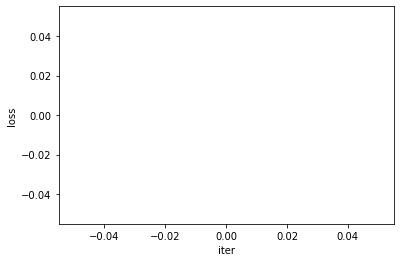

In [50]:
plt.plot(range(len(svi_result.losses)), svi_result.losses)
plt.xlabel('iter')
plt.ylabel('loss')
plt.show()

In [51]:
svi_result.losses[:10]

DeviceArray([inf, nan, nan, nan, nan, nan, nan, nan, nan, nan], dtype=float32)

In [52]:
svi_result

SVIRunResult(params={'expose_a_auto_loc': DeviceArray([10.408514], dtype=float32), 'expose_nb_r': DeviceArray([10000.], dtype=float32), 'expose_rt_auto_loc': DeviceArray([0.49982628, 0.5012576 , 0.49373427, 0.5101888 , 0.4836032 ,
             0.50987655, 0.5224794 , 0.4774043 , 0.5009213 , 0.4970597 ,
             0.4858676 , 0.5034372 , 0.4826163 , 0.49329188, 0.5269934 ,
             0.49798888, 0.5342502 , 0.5006607 , 0.4526397 , 0.48280412,
             0.50979507, 0.50148803, 0.49286267, 0.53539944, 0.49907112,
             0.47602165, 0.48673046, 0.47908574, 0.48502165, 0.5055511 ,
             0.47702357, 0.5035155 , 0.47835395, 0.5045543 , 0.47244957,
             0.50349146, 0.5147131 , 0.5106481 , 0.47188577, 0.5161721 ,
             0.5060122 , 0.5009858 , 0.50761884, 0.5193065 , 0.5289931 ,
             0.50613475, 0.48438343, 0.48973334, 0.48732522, 0.50883436,
             0.4967072 , 0.51676095, 0.5269567 , 0.500773  , 0.49269137,
             0.4649034 , 0.48627824, 0.

In [53]:
mcmc_results = run_numpyro_model(model_1, numpyro_data_dict, inference='mcmc')

INFO:__main__:Starting MCMC...


cn_prev (170, 1)
trans_mat (13, 13)
temp_cn_prob (170, 1, 13)
cn (170, 1)
rt (200,)
t (170, 1)
time_diff (170, 1)
p_rep (170, 1)
rep (170, 1)
rep_cn (170, 1)
u (170, 1)
y (170, 1)
cn_prev (170, 1)
trans_mat (13, 13)
temp_cn_prob (170, 1, 13)
cn (13, 1, 1)
rt (200,)
t (170, 1)
time_diff (170, 1)
p_rep (170, 1)
rep (2, 1, 1, 1)
rep_cn (2, 13, 1, 1)
u (170, 1)
y (170, 1)
cn_prev (13, 1, 1)
trans_mat (13, 13)
temp_cn_prob (13, 1, 1, 13)
cn (13, 1, 1, 1, 1)
rt (200,)
t (170, 1)
time_diff (170, 1)
p_rep (170, 1)
rep (2, 1, 1, 1, 1, 1)
rep_cn (2, 13, 1, 1, 1, 1)
u (170, 1)
y (170, 1)


ValueError: Invalid shape: expected (), actual (1,)

In [ ]:
temp_model_1 = numpyro.handlers.seed(model_1, rng_key)
trace = numpyro.handlers.trace(temp_model_1).get_trace({'data': jnp.array(reads), 
                                                        'cn_prior': jnp.array(cn_prior),
                                                        'trans_mat': jnp.array(trans_mat)})

plate_warning = 'error'
for name, site in trace.items():
    print(name, site['type'])
    if site['type'] == 'sample':
        value_ndim = jnp.ndim(site['value'])
        print('value_ndim', value_ndim)
        batch_shape = lax.broadcast_shapes(
                    tuple(site["fn"].batch_shape),
                    jnp.shape(site["value"])[: value_ndim - len(site["fn"].event_shape)],
                )
        print('batch_shape', batch_shape)
        plate_dims = set(f.dim for f in site['cond_indep_stack'])
        print('plate_dims', plate_dims)
        batch_ndim = len(batch_shape)
        print('batch_ndim', batch_ndim)
        for i in range(batch_ndim):
            dim = -i - 1
            print('i', i, 'dim', dim)
            print('batch_shape[dim]', batch_shape[dim])
            print('dim in plate_dims', (dim in plate_dims))
            if batch_shape[dim] > 1 and (dim not in plate_dims):
                # Skip checking if it is the `scan` dimension.
                print('inside first if')
                print('control flow done', site.get('_control_flow_done'))
                if dim == -batch_ndim and site.get("_control_flow_done", False):
                    print('continuing')
                    continue
                message = (
                    f"Missing a plate statement for batch dimension {dim}"
                    f" at site '{name}'. You can use `numpyro.util.format_shapes`"
                    " utility to check shapes at all sites of your model."
                )

                if plate_warning == "error":
                    raise ValueError(message)
                elif plate_warning == "strict" or (len(plate_dims) > 0):
                    warnings.warn(message, stacklevel=find_stack_level())

